In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from dataloader import *

sns.set(style='ticks', context='talk')
plt.style.use("paper.mplstyle")

Missing from R19 Table 1 of SNID: {15459}
Missing from Campbell MCMC chains of SNID: {3256}
Resulting data will be an inner join of the two


,age
snid,
762,2.021842
762,2.833909
762,2.580368
762,2.397617
762,2.629097


,hr,hr_err
snid,,
762,0.15,0.08
1032,-0.15,0.12
1371,-0.14,0.06
1794,0.27,0.08
2372,-0.12,0.07


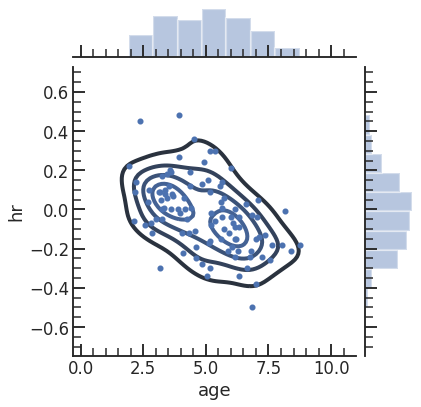

In [2]:
# load_age_sample_from_mcmc_chains('campbell', mode="write")
age_df = load_age_sample_from_mcmc_chains('campbell', mode="read")
age_df = age_df.set_index("snid").sort_index()

hr_df = load_hr("campbell")
hr_df = hr_df
hr_df.columns = hr_df.columns.str.lower()
hr_df = (hr_df.rename(columns={
    "sdss": "snid",
    "e_hr": "hr_err"
})
         .set_index("snid")
         .sort_index()[["hr", "hr_err"]])

in_age_not_hr = set(age_df.index) - set(hr_df.index)
in_hr_not_age = set(hr_df.index) - set(age_df.index)
print("Missing from R19 Table 1 of SNID:", in_age_not_hr)
print("Missing from Campbell MCMC chains of SNID:", in_hr_not_age)

print("Resulting data will be an inner join of the two")
age_df = age_df.drop(index=in_age_not_hr)
hr_df = hr_df.drop(index=in_hr_not_age)
snids = age_df.index.unique().tolist()

display(age_df.head())
display(hr_df.head())

# Joint plot of Age and HR row means
sns.jointplot( age_df.groupby('snid').mean()['age'], hr_df['hr'], s=15).plot_joint(sns.kdeplot, zorder=0, n_levels=4);

In [3]:
from linmix import linmix

age_mean = age_df['age'].groupby('snid').mean().to_numpy()
age_sd = age_df['age'].groupby('snid').std().to_numpy()

lm1 = linmix.LinMix(age_mean, hr_df['hr'], xsig=None, ysig=hr_df['hr_err'], K=3, seed=912)
lm1.run_mcmc(maxiter=5000)

lm2 = linmix.LinMix(age_mean, hr_df['hr'], xsig=age_sd, ysig=hr_df['hr_err'], K=3, seed=912)
lm2.run_mcmc(maxiter=5000)


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99648043 0.99214278 1.0447102  1.03060888 1.02230651 0.99030962]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99968112 0.99995859 1.00572337 1.00379583 1.00907124 0.99884357]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99903966 0.99750924 1.01450305 1.00337382 1.00897494 1.00026539]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00331048 1.0008763  1.00756574 1.00239115 0.99961829 1.00160637]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00285707 1.00121249 1.00784379 1.00420117 0.99969638 1.00092858]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00409139 1.00297444 1

Text(0.5, 0, 'Slope')

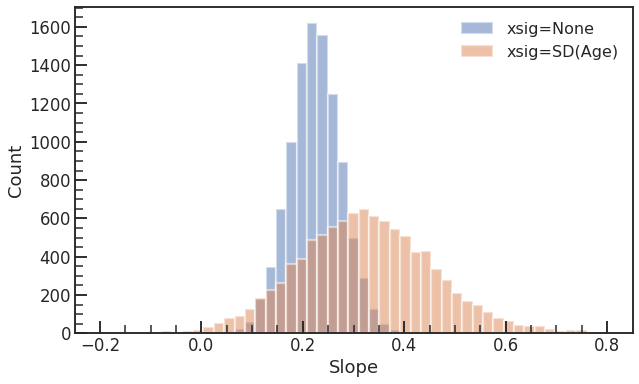

In [4]:
bins = np.linspace(-0.2, 0.8, 50)
plt.hist(lm1.chain["alpha"], bins, alpha=0.5, label="xsig=None")
plt.hist(lm2.chain["alpha"], bins, alpha=0.5, label="xsig=SD(Age)")
plt.legend()
plt.ylabel("Count")
plt.xlabel("Slope")